In [44]:
import torch
from IPython.core.pylabtools import figsize
from sympy.solvers.diophantine.diophantine import reconstruct
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numba
import TorchData
from sklearn.metrics import roc_auc_score, roc_curve

from TorchData import TORCHData

In [45]:
import importlib
importlib.reload(TorchData)

<module 'TorchData' from 'F:\\projects\\ResearchProject\\TorchData\\__init__.py'>

In [46]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [47]:
train_dataset = TorchData.TORCHDataset(num_data=5096)
test_dataset = TorchData.TORCHDataset(num_data=1024)

train_dataloader = train_dataset.dataloader(batch_size=256, shuffle=True)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

In [48]:
class HybridTransformer(torch.nn.Module):
    def __init__(self, embed_dim=64, num_heads=1, num_layers=2):
        super().__init__()
        
        # CNN Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(4, 32),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(8, 64),
            torch.nn.MaxPool2d(2)
        )

        # Transformer
        self.transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=512,
                batch_first=True,
                norm_first=True
            ),
            num_layers=num_layers
        )
        
        # CNN Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(8, 64),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(4, 32),
            torch.nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

        self.pos_embed = torch.nn.Parameter(torch.randn(1, 690, embed_dim))

    def forward(self, x):
        # Encoder
        cnn_features = self.encoder(x)  # [B, 64, H/4, W/4]
        
        # Transformer processing
        B, C, H, W = cnn_features.shape
        x = cnn_features.flatten(2).permute(0, 2, 1)  # [B, Seq, C]

        x = x + self.pos_embed[:, :H*W, :]  # Positional embedding
        x = self.transformer(x)
        
        # Feature fusion
        x = x.permute(0, 2, 1).view(B, C, H, W)
        x = x + cnn_features  # Residual connection
        
        # Decoder pathway
        return self.decoder(x)

In [49]:
model = HybridTransformer().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

F:\projects\ResearchProject\venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [7]:
summary(model, input_size=(1, 1, 120, 92))

NameError: name 'model' is not defined

In [8]:
for epoch in tqdm(range(100)):
    for sn_time, signal_time in train_dataloader:
        optimiser.zero_grad()
        outputs = model(sn_time.to(device))
        loss = loss_function(outputs, signal_time.to(device))
        loss.backward()
        optimiser.step()

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'train_dataloader' is not defined

In [50]:
### Using pretrained weights
model.load_state_dict(torch.load("ModelWeights/HybridTransformer/HybridTransformer_1024_256_3000.pth", weights_only=True))

<All keys matched successfully>

In [51]:
model.eval()

all_pred = []
with torch.no_grad():
    for sn_time, signal_time in test_dataloader:
        pred = model.to("cpu")(sn_time.to("cpu"))
        all_pred.append(pred)
    all_pred = torch.cat(all_pred)

all_pred_time = all_pred * test_dataset.sn_time
all_pred_time[all_pred_time < 0.5] = 0

F:\projects\ResearchProject\TorchData\__init__.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  def __init__(self, t=100, x=120, y=92, n_remove=50, num_data = 1):


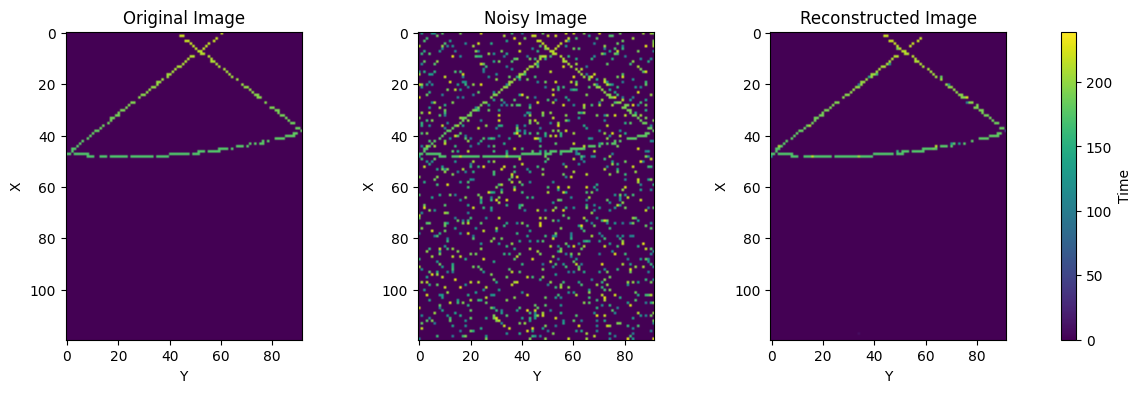

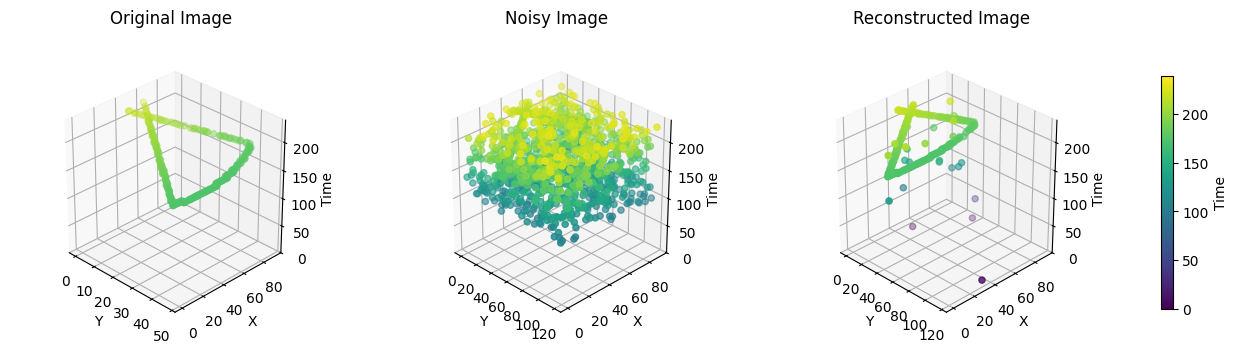

In [52]:
TorchData.visual.fast_compare_plot(test_dataset, all_pred_time, 0)

In [59]:
mse = TorchData.metric.calculate_mse_torch(test_dataset.signal_time, all_pred_time)
psnr = TorchData.metric.calculate_psnr_torch(test_dataset.signal_time, all_pred_time)
ssim = TorchData.metric.calculate_ssim_torch(test_dataset.signal_time, all_pred_time)
roc_auc = roc_auc_score(test_dataset.signal.flatten().numpy(), all_pred_time.flatten().numpy())
print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, ROC AUC: {roc_auc:.4f}")

MSE: 102.4658, PSNR: 26.7427, SSIM: 0.9506, ROC AUC: 0.9949
